# Data Analyst Take-Home Test: Payment Industry Case Study (DuckDB Version)
This notebook provides an analysis of payment transaction data, merchant details, and chargeback records using **DuckDB** for SQL-based querying.

## **Objectives:**
- **Understand trends in transaction volume and revenue**.
- **Identify top-performing merchants**.
- **Detect potential fraudulent activities**.
- **Assess the impact of failed transactions on revenue**.
- **Recommend strategies to improve transaction success rates**.

## **Dataset Information:**
- **transactions.xlsx**: Contains transaction records.
- **merchants.xlsx**: Contains merchant details.
- **chargebacks.xlsx**: Contains chargeback data (disputed transactions).

In [2]:

import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")

# Load the datasets
transactions_path = "transactions.xlsx"
merchants_path = "merchants.xlsx"
chargebacks_path = "chargebacks.xlsx"

# Read data into Pandas DataFrames
transactions = pd.read_excel(transactions_path)
merchants = pd.read_excel(merchants_path)
chargebacks = pd.read_excel(chargebacks_path)

# Convert date columns only if necessary
if transactions['transaction_date'].dtype != 'datetime64[ns]':
    transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

if chargebacks['chargeback_date'].dtype != 'datetime64[ns]':
    chargebacks['chargeback_date'] = pd.to_datetime(chargebacks['chargeback_date'])

# Create an in-memory DuckDB database
con = duckdb.connect(database=':memory:')

# Load data into DuckDB
con.register('transactions', transactions)
con.register('merchants', merchants)
con.register('chargebacks', chargebacks)


ImportError: cannot import name 'cbook' from partially initialized module 'matplotlib' (most likely due to a circular import) (C:\Users\Aoladapo2\AppData\Local\anaconda3\Lib\site-packages\matplotlib\__init__.py)

In [3]:

# Query revenue and transaction trends using DuckDB
query = '''
SELECT 
    DATE_TRUNC('day', transaction_date) AS transaction_day, 
    COUNT(transaction_id) AS transaction_count, 
    SUM(transaction_amount) AS total_revenue
FROM transactions
GROUP BY transaction_day
ORDER BY transaction_day
'''
daily_trends = con.execute(query).fetchdf()

# Plot revenue trend
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_trends['transaction_day'], y=daily_trends['total_revenue'], marker='o', color='blue')
plt.title("Daily Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Total Revenue (USD)")
plt.xticks(rotation=45)
plt.show()

# Plot transaction volume trend
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_trends['transaction_day'], y=daily_trends['transaction_count'], marker='o', color='green')
plt.title("Daily Transaction Volume Trend")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.show()


NameError: name 'con' is not defined

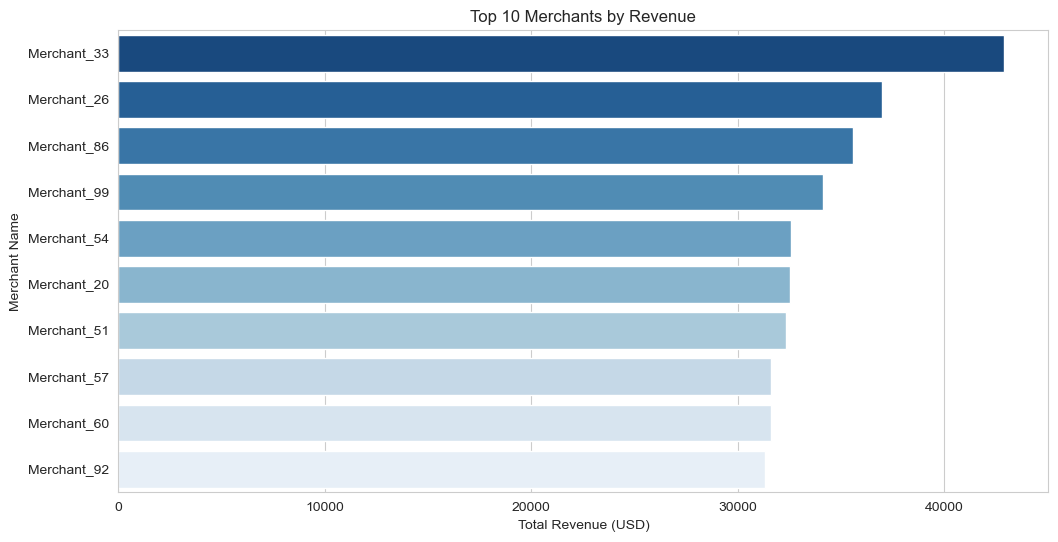

In [5]:

# Query top merchants by revenue
query = '''
SELECT 
    t.merchant_id, 
    m.merchant_name, 
    SUM(t.transaction_amount) AS total_revenue
FROM transactions t
JOIN merchants m ON t.merchant_id = m.merchant_id
GROUP BY t.merchant_id, m.merchant_name
ORDER BY total_revenue DESC
LIMIT 10
'''
top_merchants_df = con.execute(query).fetchdf()

# Plot top merchants
plt.figure(figsize=(12, 6))
sns.barplot(x=top_merchants_df["total_revenue"], y=top_merchants_df["merchant_name"], palette="Blues_r")
plt.title("Top 10 Merchants by Revenue")
plt.xlabel("Total Revenue (USD)")
plt.ylabel("Merchant Name")
plt.show()


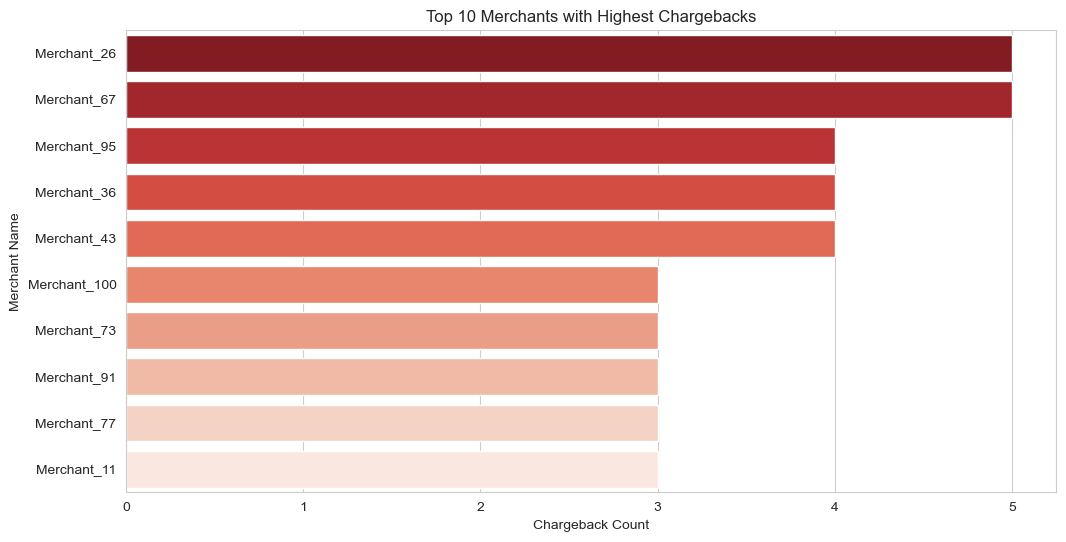

In [6]:

# Query chargeback rates per merchant
query = '''
SELECT 
    t.merchant_id, 
    m.merchant_name,
    COUNT(c.chargeback_id) AS chargeback_count,
    SUM(c.chargeback_amount) AS total_chargeback_amount
FROM chargebacks c
JOIN transactions t ON c.transaction_id = t.transaction_id
JOIN merchants m ON t.merchant_id = m.merchant_id
GROUP BY t.merchant_id, m.merchant_name
ORDER BY chargeback_count DESC
LIMIT 10
'''
top_chargeback_merchants = con.execute(query).fetchdf()

# Visualize chargeback rates
plt.figure(figsize=(12, 6))
sns.barplot(x=top_chargeback_merchants["chargeback_count"], y=top_chargeback_merchants["merchant_name"], palette="Reds_r")
plt.title("Top 10 Merchants with Highest Chargebacks")
plt.xlabel("Chargeback Count")
plt.ylabel("Merchant Name")
plt.show()


In [7]:
# Query total revenue lost due to failed transactions
query = '''
SELECT 
    SUM(transaction_amount) AS failed_revenue_loss
FROM transactions
WHERE status = 'failed'
'''
failed_revenue_loss = con.execute(query).fetchdf().iloc[0, 0]

print(f"Total Revenue Lost Due to Failed Transactions: ${failed_revenue_loss:,.2f}")


Total Revenue Lost Due to Failed Transactions: $271,017.18


## **Business Recommendations**
### **1. Improve Transaction Success Rates**
- Identify merchants with high failure rates and address issues.
- Improve payment gateway reliability and error handling.

### **2. Reduce Fraud & Chargebacks**
- Monitor merchants with high chargeback rates.
- Enforce two-factor authentication for high-value transactions.

### **3. Expand Profitable Segments**
- Focus on high-revenue merchants and encourage repeat business.
- Provide incentives for top-performing categories.

### **4. Optimize Payment Methods**
- Identify underperforming payment methods and optimize their usage.
- Encourage customers to use more successful payment channels.